In [44]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Set random seed for reproducibility
RANDOM_STATE = 42

In [63]:
# 1. Loading the Dataset
print("Loading dataset...")
df = pd.read_csv("Duolingo_data_03_06.csv")
pd.set_option('display.max_columns', None)
df

Loading dataset...


,user_id,block_average_correctness,reverse_tap_average_correctness,reverse_translate_average_correctness,listen_average_correctness,block_average_response_time,reverse_tap_average_response_time,reverse_translate_average_response_time,listen_average_response_time,user_ability_score,average_blocks_per_session,average_blocks_per_day,average_sessions_per_day,session_length_variance,blocks_per_session_variance,blocks_per_day_variance,sessions_per_day_variance,session_count,listen,reverse_tap,reverse_translate,response_time_variance,churn_time,churn_time_category
0,+4kwmfjD,0.227673,0.133858,0.378947,0.375000,8.138365,6.614173,14.968421,13.763889,0.610942,53.000000,159.000000,3.00,12142.333333,1813.000000,0.000000,0.000000,3,27,96,36,48.512380,0.0,1
1,+IUzKF2l,0.332900,0.212815,0.500000,0.607595,8.745455,6.995238,14.187500,17.155844,0.646135,21.000000,21.000000,1.00,604.818182,87.400000,87.400000,0.000000,11,37,163,31,60.254545,22.0,4
2,+Xv/6Nop,0.229710,0.140162,0.375000,0.397849,12.295652,9.417790,17.423077,23.688172,0.606883,32.857143,46.000000,1.60,2669.142857,565.142857,1901.500000,0.800000,7,40,151,39,1171.204785,5.0,1
3,+mMyHsNU,0.239135,0.000000,0.250307,0.225892,10.729670,0.000000,10.867485,13.401585,0.613978,35.000000,91.000000,2.60,14049.910256,1082.333333,3364.000000,2.300000,13,219,0,236,169.677862,6.0,1
4,+ziSnwWC,0.169845,0.065789,0.266409,0.328947,12.036199,5.109649,21.324324,16.921053,0.590596,10.523810,18.416667,1.75,569.661905,103.561905,237.719697,0.931818,21,36,107,78,141.807775,13.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,y6797eWc,0.076945,0.015957,0.202454,0.090909,8.955414,3.042553,19.411043,15.272727,0.545205,15.700000,39.250000,2.50,430.177778,26.900000,370.916667,1.666667,10,29,84,44,486.017230,3.0,1
308,yka558y8,0.144504,0.103175,0.166065,0.175000,30.436170,3.031746,32.227437,98.987500,0.559939,20.888889,47.000000,2.25,2368.250000,498.861111,6418.666667,3.583333,9,36,55,97,54144.632268,4.0,1
309,z/C43yrd,0.069785,0.044248,0.175258,0.088889,10.225806,6.415929,26.010309,14.400000,0.536617,11.071429,22.142857,2.00,850.219780,197.609890,633.142857,1.666667,14,23,100,32,108.007122,6.0,1
310,z9FlLLzt,0.122254,0.000000,0.104911,0.105263,13.271676,0.000000,15.243304,12.210526,0.545946,19.222222,43.250000,2.25,1072.861111,124.194444,196.250000,0.250000,9,27,0,146,87.326926,3.0,1


In [64]:
max_variance = df["sessions_per_day_variance"].max()
print(f"Maximum value: {max_variance}")

Maximum value: 12.5


In [65]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nSummary statistics:")
print(df.describe())

Dataset shape: (312, 24)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   user_id                                  312 non-null    object 
 1   block_average_correctness                312 non-null    float64
 2   reverse_tap_average_correctness          312 non-null    float64
 3   reverse_translate_average_correctness    312 non-null    float64
 4   listen_average_correctness               312 non-null    float64
 5   block_average_response_time              312 non-null    float64
 6   reverse_tap_average_response_time        312 non-null    float64
 7   reverse_translate_average_response_time  312 non-null    float64
 8   listen_average_response_time             312 non-null    float64
 9   user_ability_score                       312 non-null    float64
 10  average_bl

In [66]:
# 2. Data Preprocessing
print("\nChecking for missing values:")
print(df.isnull().sum())

# Convert churn_time_category to categorical target (binary classification)
# Let's consider categories 3 and 4 as "will churn" (1) and categories 1 and 2 as "will not churn" (0)
# df['will_churn'] = df['churn_time_category'].apply(lambda x: 1 if x >= 3 else 0)

print("\nTarget distribution:")
print(df['churn_time_category'].value_counts())
# print(df['1'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))


Checking for missing values:
user_id                                    0
block_average_correctness                  0
reverse_tap_average_correctness            0
reverse_translate_average_correctness      0
listen_average_correctness                 0
block_average_response_time                0
reverse_tap_average_response_time          0
reverse_translate_average_response_time    0
listen_average_response_time               0
user_ability_score                         0
average_blocks_per_session                 0
average_blocks_per_day                     0
average_sessions_per_day                   0
session_length_variance                    0
blocks_per_session_variance                0
blocks_per_day_variance                    0
sessions_per_day_variance                  0
session_count                              0
listen                                     0
reverse_tap                                0
reverse_translate                          0
response_time_variance   

In [32]:
# 3. Feature Selection
# Exclude the original target, churn_time (which would cause data leakage), and any other columns we don't want as features
features = [col for col in df.columns if col not in ['churn_time_category', 'will_churn', 'user_id', 'churn_time']]
X = df[features]
y = df['will_churn']

print("\nSelected features:", features)


Selected features: ['student_average_correctness', 'session_count', 'listen', 'reverse_tap', 'reverse_translate', 'block_wise_token_easiness', 'response_time_variance']


In [33]:
# 4. Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 249
Testing samples: 63


In [34]:
# 5. Train a basic Random Forest model
print("\nTraining a basic Random Forest model...")
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)


Training a basic Random Forest model...


RandomForestClassifier(random_state=42)


Basic model accuracy: 0.7143

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        47
           1       0.40      0.25      0.31        16

    accuracy                           0.71        63
   macro avg       0.59      0.56      0.56        63
weighted avg       0.68      0.71      0.69        63


Confusion Matrix:
[[41  6]
 [12  4]]


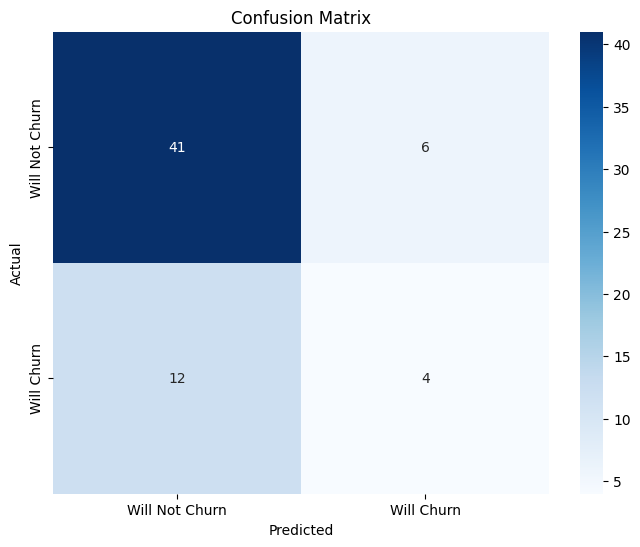

In [35]:
# 6. Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBasic model accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 7. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Will Not Churn', 'Will Churn'],
            yticklabels=['Will Not Churn', 'Will Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Feature Importance:
                       Feature  Importance
1                session_count    0.209998
2                       listen    0.167442
6       response_time_variance    0.141316
5    block_wise_token_easiness    0.137941
0  student_average_correctness    0.122508
3                  reverse_tap    0.113974
4            reverse_translate    0.106822


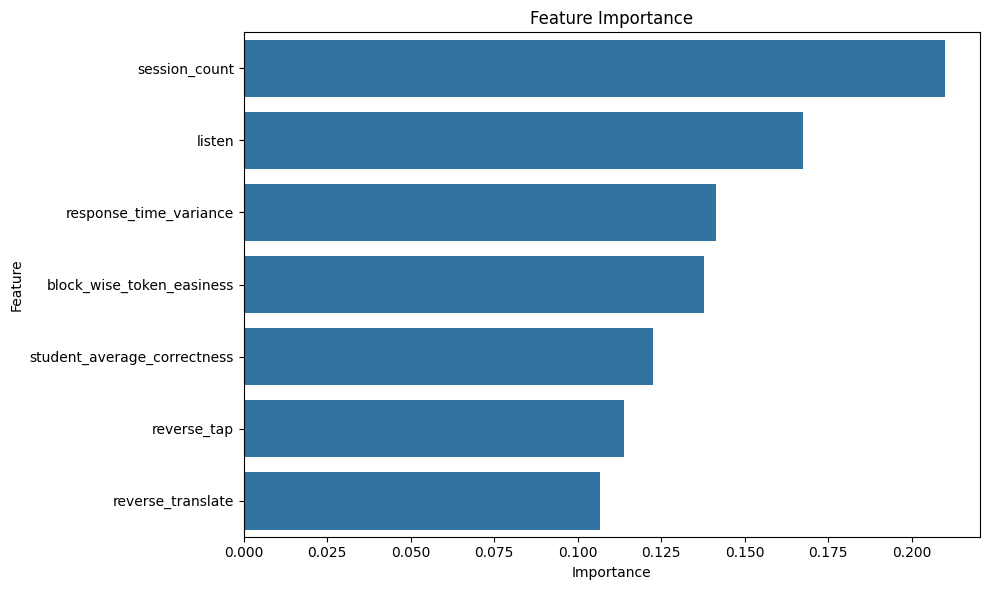

In [36]:
# 8. Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [37]:
# 9. Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

print("\nPerforming hyperparameter tuning...")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use a smaller subset for quick demonstration
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))



Performing hyperparameter tuning...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.7831


In [38]:
# 10. Evaluate the tuned model
best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned model accuracy: {accuracy_tuned:.4f}")

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))



Tuned model accuracy: 0.7460

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        47
           1       0.50      0.31      0.38        16

    accuracy                           0.75        63
   macro avg       0.65      0.60      0.61        63
weighted avg       0.72      0.75      0.72        63



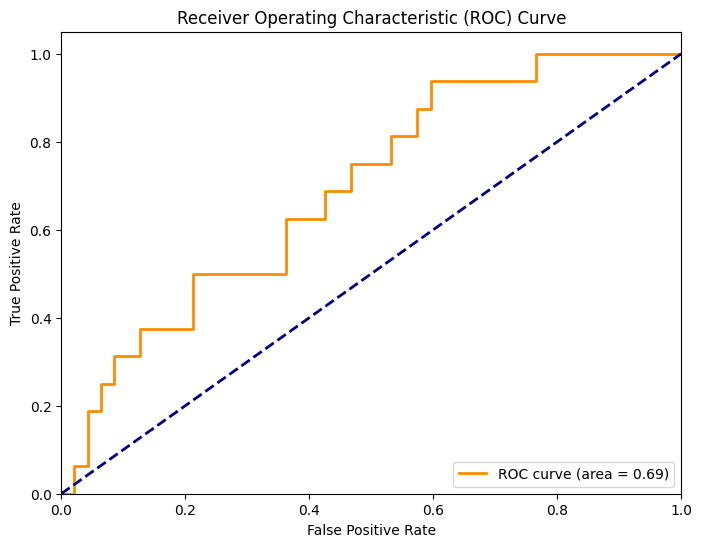


Generating learning curves...


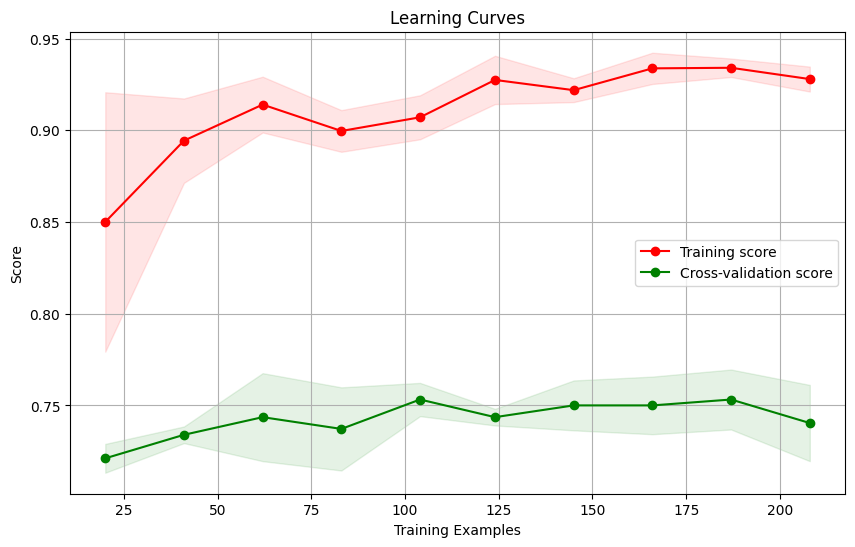


Analysis complete.


In [43]:
# 11. ROC Curve
y_prob = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 12. Learning Curves
from sklearn.model_selection import learning_curve

print("\nGenerating learning curves...")
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model, X, y, cv=3, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', random_state=RANDOM_STATE
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print("\nAnalysis complete.")